In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df


In [3]:
def get_human_dataset( ):
   
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
   
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
   
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
   
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
   
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
   
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test


In [4]:
# 데이터 준비
X_train, X_test, y_train, y_test = get_human_dataset()

In [6]:
# 1. 베이스 모델 생성
rf_clf = RandomForestClassifier(
      n_estimators=1000
    , random_state=0
    , max_depth=8
)
# 2. 학습데이터 학습
rf_clf.fit(X_train, y_train)
# 3. 테스트데이터 예측값 추출
pred = rf_clf.predict(X_test)
# 4. 평가 : 정확도
acc = accuracy_score(y_test, pred)
print(f'랜덤포레스트 정확도 : {acc:.4f}')

랜덤포레스트 정확도 : 0.9165


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [8]:
from sklearn.model_selection import GridSearchCV

params = {
      'max_depth' : [8,16,24]
    , 'min_samples_leaf' : [1,6,12]
    , 'min_samples_split' : [2,8,16]
}
rf_clf = RandomForestClassifier(
      n_estimators=100
    , random_state=0
    , n_jobs=-1
)
grid_cv = GridSearchCV(
    rf_clf
    , param_grid=params
    , cv=2
    , n_jobs=-1
)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [8, 16, 24],
                         'min_samples_leaf': [1, 6, 12],
                         'min_samples_split': [2, 8, 16]})

In [9]:
grid_cv.best_params_

{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [10]:
grid_cv.best_score_

0.9164853101196953

In [11]:
rf_clf = RandomForestClassifier(
      n_estimators=100
    , min_samples_leaf=6
    , max_depth=16
    , min_samples_split=2
    , random_state=0
)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'정확도 : {acc:.4f}')

정확도 : 0.9260


In [12]:
# 중요도 시각화
ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(
      ftr_importances_values
    , index=X_train.columns
)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
ftr_top20

angle(X,gravityMean)               0.035312
tGravityAcc-mean()-Y               0.033729
tGravityAcc-min()-X                0.030276
angle(Y,gravityMean)               0.029013
tGravityAcc-max()-X                0.027538
tGravityAcc-mean()-X               0.024708
tGravityAcc-energy()-X             0.024389
tGravityAcc-min()-Y                0.023339
tGravityAcc-max()-Y                0.021011
fBodyAccJerk-bandsEnergy()-1,8     0.018636
tGravityAcc-energy()-Y             0.015461
tBodyAcc-max()-X                   0.013750
tBodyAccJerk-entropy()-X           0.013433
tGravityAcc-arCoeff()-Z,1          0.013150
tGravityAcc-max()-Z                0.013125
fBodyAccMag-energy()               0.012262
tGravityAcc-energy()-Z             0.010683
fBodyAccJerk-bandsEnergy()-1,16    0.010095
fBodyAcc-mad()-X                   0.010036
angle(Z,gravityMean)               0.009483
dtype: float64

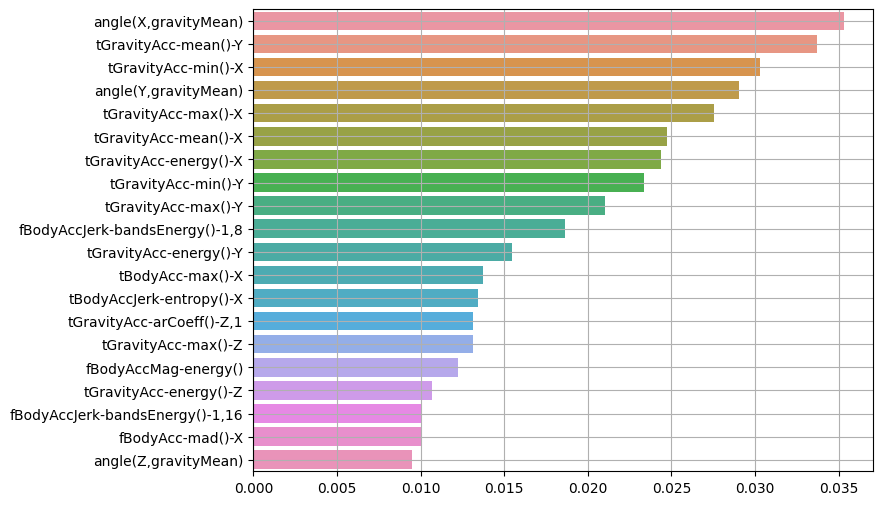

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.grid()
plt.show()